In [1]:
# 1. Imports and Data loading
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import radius_neighbors_graph
import seaborn as sns

# Generate concentric circles with noise
X, y_true = make_circles(n_samples=80, factor=0.3, noise=0.1, random_state=42)

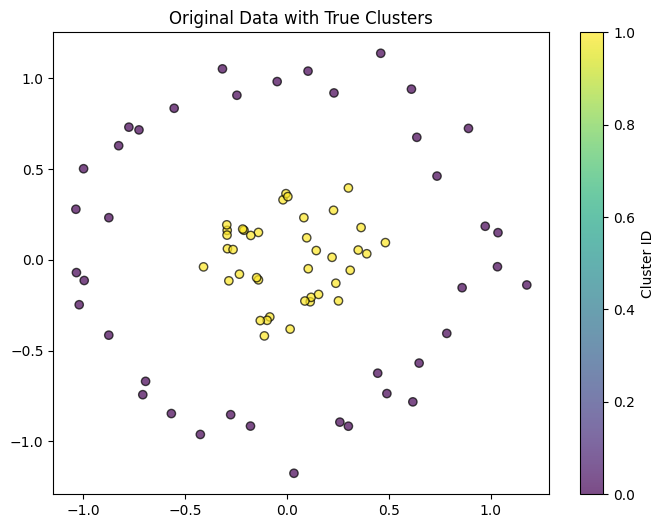

In [2]:
# 2. Data Visualization
# Show challenging non-linear structure

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', edgecolors='k', alpha=0.7)
plt.title("Original Data with True Clusters")
plt.colorbar(label="Cluster ID")
plt.show()

In [3]:
# 3. Data Preprocessing
# Scale data and compute similarity matrix

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute adjacency matrix (neighborhood graph)
connectivity = radius_neighbors_graph(X_scaled, radius=0.4, mode='connectivity')

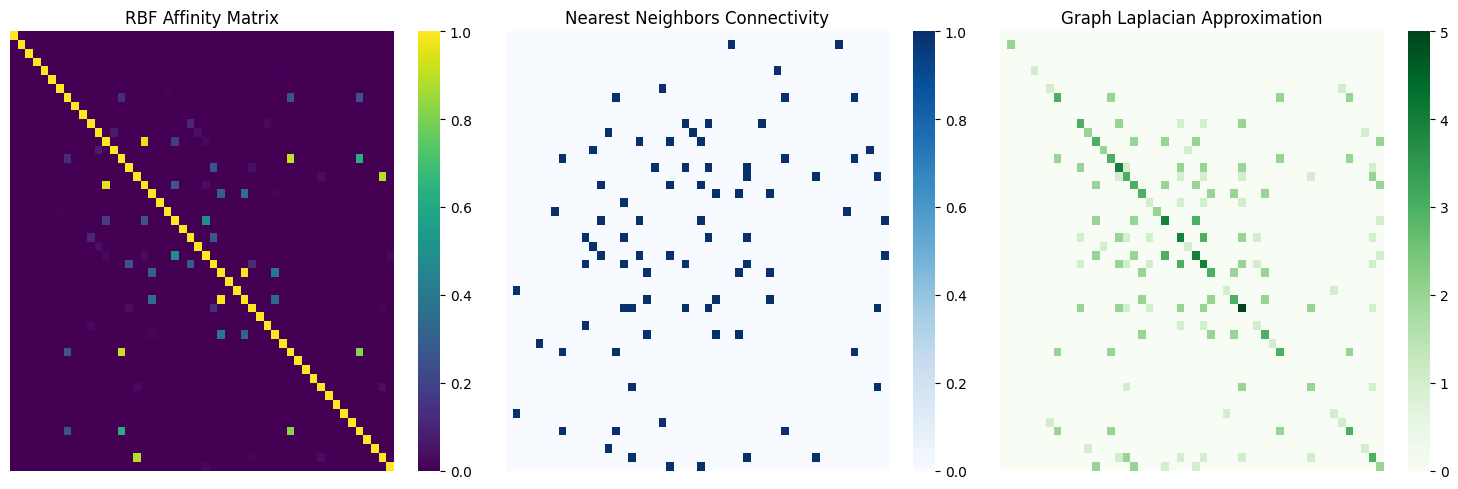

In [4]:
# 4. Affinity Matrix Visualization
# Compare different similarity representations

plt.figure(figsize=(15, 5))

# Radial Basis Function (RBF) affinity
plt.subplot(1, 3, 1)
rbf_affinity = np.exp(-0.5 * np.square(X_scaled[:, None] - X_scaled).sum(2)/0.1**2)
sns.heatmap(rbf_affinity[:50, :50], cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("RBF Affinity Matrix")

# Nearest Neighbors affinity
plt.subplot(1, 3, 2)
sns.heatmap(connectivity[:50, :50].toarray(), cmap='Blues', xticklabels=False, yticklabels=False)
plt.title("Nearest Neighbors Connectivity")

# Graph Laplacian approximation
plt.subplot(1, 3, 3)
laplacian_approx = (connectivity[:50, :50] @ connectivity[:50, :50].T).toarray()
sns.heatmap(laplacian_approx, cmap='Greens', xticklabels=False, yticklabels=False)
plt.title("Graph Laplacian Approximation")

plt.tight_layout()
plt.show()

In [5]:
# 5. Parameter Sensitivity Analysis
# Test different affinity types and gamma values

param_grid = {
    'affinity': ['rbf', 'nearest_neighbors'],
    'gamma': [0.1, 1, 10],
    'n_clusters': [2, 3, 4]
}

results = []
for affinity in param_grid['affinity']:
    for gamma in param_grid['gamma']:
        for n_clusters in param_grid['n_clusters']:
            if affinity == 'nearest_neighbors' and gamma != 1:
                continue  # Gamma not used for NN affinity

            sc = SpectralClustering(
                n_clusters=n_clusters,
                affinity=affinity,
                gamma=gamma,
                random_state=42
            )
            labels = sc.fit_predict(X_scaled)

            if len(np.unique(labels)) > 1:  # Silhouette needs >1 cluster
                sil_score = silhouette_score(X_scaled, labels)
            else:
                sil_score = -1

            results.append({
                'affinity': affinity,
                'gamma': gamma,
                'n_clusters': n_clusters,
                'silhouette': sil_score
            })

results_df = pd.DataFrame(results)

<ipython-input-6-4f886cbad202>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:379: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-.5, n - .5, auto=None)


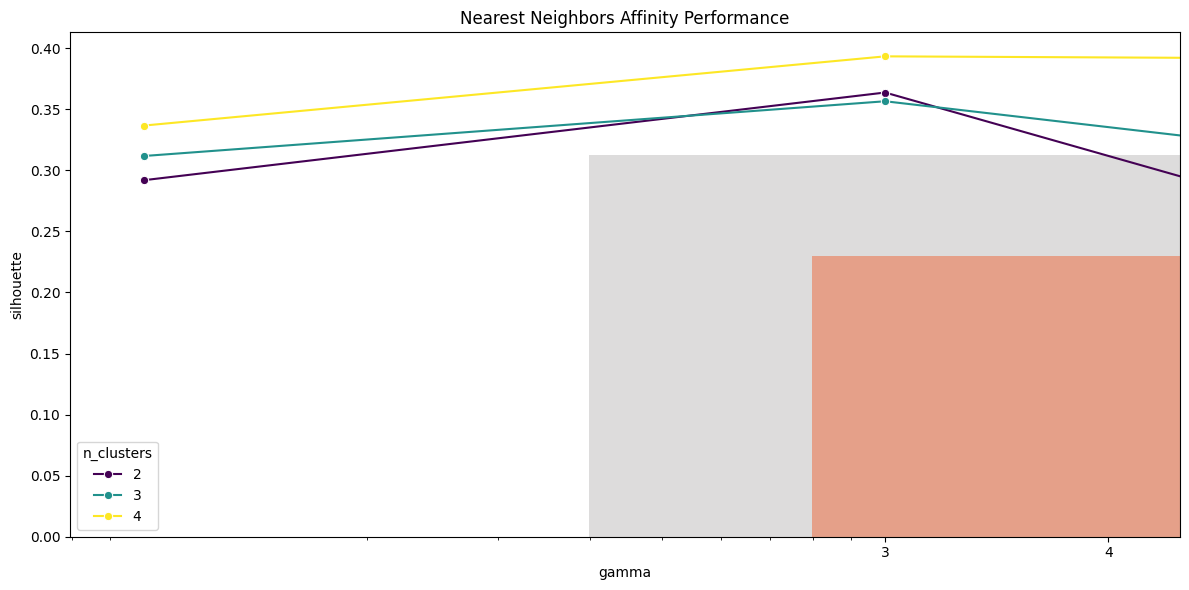

In [6]:
# 6. Parameter Optimization
# Identify best parameters through grid search

plt.figure(figsize=(12, 6))

# RBF Affinity Results
rbf_df = results_df[results_df['affinity'] == 'rbf']
sns.lineplot(
    data=rbf_df,
    x='gamma',
    y='silhouette',
    hue='n_clusters',
    marker='o',
    palette='viridis'
)
plt.title("RBF Affinity Performance")
plt.xscale('log')

# Nearest Neighbors Affinity Results
nn_df = results_df[results_df['affinity'] == 'nearest_neighbors']
sns.barplot(
    data=nn_df,
    x='n_clusters',
    y='silhouette',
    palette='coolwarm'
)
plt.title("Nearest Neighbors Affinity Performance")

plt.tight_layout()
plt.show()

In [7]:
# 7. Final Model Implementation
# Using optimal parameters from analysis

best_params = {
    'affinity': 'rbf',
    'gamma': 10,
    'n_clusters': 2
}

final_sc = SpectralClustering(
    n_clusters=best_params['n_clusters'],
    affinity=best_params['affinity'],
    gamma=best_params['gamma'],
    random_state=42
)
sc_labels = final_sc.fit_predict(X_scaled)

Silhouette Score: 0.191
Adjusted Rand Index: 1.000


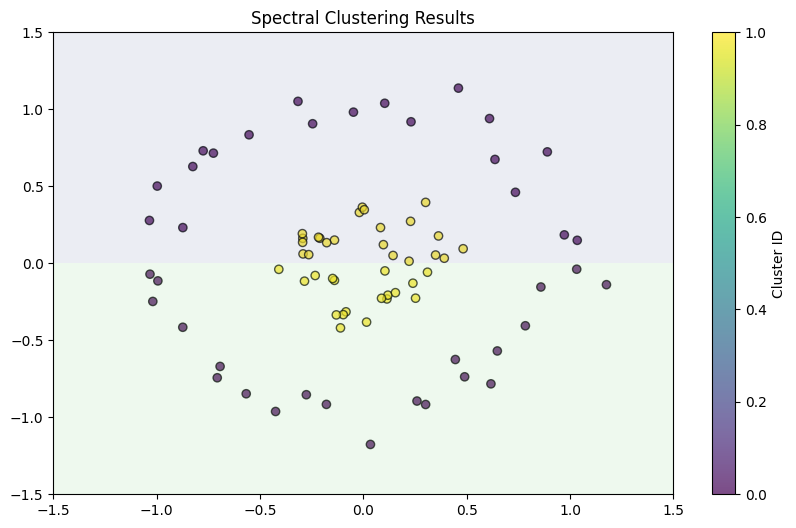

In [8]:
# 8. Evaluation
# Validate clustering quality and visualize

# Calculate metrics
sil_score = silhouette_score(X_scaled, sc_labels)
ari_score = adjusted_rand_score(y_true, sc_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Adjusted Rand Index: {ari_score:.3f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=sc_labels, cmap='viridis', edgecolors='k', alpha=0.7)
plt.title("Spectral Clustering Results")
plt.colorbar(label="Cluster ID")

# Plot decision boundaries
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 80), np.linspace(-1.5, 1.5, 80))
grid_points = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
Z = final_sc.fit_predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.1, levels=np.arange(-0.5, best_params['n_clusters']))
plt.show()